In [7]:
#!pip list

%matplotlib inline

import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import pickle
# Some nice output
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display, Markdown

import dbmsbenchmarker
import bexhoma
from bexhoma import evaluators
#import evaluator

In [2]:
code = "1737728609"
path = "/home/perdelt/benchmarks"
evaluation = evaluators.ycsb(code=code, path=path)

In [3]:
df_benchmarks = evaluation.get_df_benchmarking()
#df = df[df.columns.drop(list(df.filter(regex='FAILED')))]
df_benchmarks = evaluation.benchmarking_set_datatypes(df_benchmarks)
df_benchmarks.T

connection_pod,PostgreSQL-64-8-196608-2-3-1,PostgreSQL-64-8-196608-2-2-1,PostgreSQL-64-8-196608-1-3-1,PostgreSQL-64-8-196608-1-3-2,PostgreSQL-64-8-196608-1-2-1,PostgreSQL-64-8-196608-2-3-2,PostgreSQL-64-8-196608-2-3-3,PostgreSQL-64-8-196608-2-3-4,PostgreSQL-64-8-196608-1-3-3,PostgreSQL-64-8-196608-1-3-4,...,PostgreSQL-64-8-196608-2-3-13,PostgreSQL-64-8-196608-2-3-14,PostgreSQL-64-8-196608-2-2-8,PostgreSQL-64-8-196608-1-2-5,PostgreSQL-64-8-196608-2-3-15,PostgreSQL-64-8-196608-2-3-16,PostgreSQL-64-8-196608-1-2-6,PostgreSQL-64-8-196608-1-2-7,PostgreSQL-64-8-196608-1-2-8,PostgreSQL-64-8-196608-1-3-16
connection,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-2-2,PostgreSQL-64-8-196608-1-3,PostgreSQL-64-8-196608-1-3,PostgreSQL-64-8-196608-1-2,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-1-3,PostgreSQL-64-8-196608-1-3,...,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-2-2,PostgreSQL-64-8-196608-1-2,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-2-3,PostgreSQL-64-8-196608-1-2,PostgreSQL-64-8-196608-1-2,PostgreSQL-64-8-196608-1-2,PostgreSQL-64-8-196608-1-3
configuration,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,...,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608
experiment_run,2,2,1,1,1,2,2,2,1,1,...,2,2,2,1,2,2,1,1,1,1
client,3,2,3,3,2,3,3,3,3,3,...,3,3,2,2,3,3,2,2,2,3
pod,7jfgp.dbmsbenchmarker,ggw72.dbmsbenchmarker,7nwj9.dbmsbenchmarker,9kc4g.dbmsbenchmarker,rr6lh.dbmsbenchmarker,lp898.dbmsbenchmarker,rzxj6.dbmsbenchmarker,v4jh8.dbmsbenchmarker,2xflt.dbmsbenchmarker,q57b8.dbmsbenchmarker,...,9mwg4.dbmsbenchmarker,kqxmp.dbmsbenchmarker,nn7x6.dbmsbenchmarker,s6xbh.dbmsbenchmarker,7g5bq.dbmsbenchmarker,622d4.dbmsbenchmarker,rblwr.dbmsbenchmarker,jvxdw.dbmsbenchmarker,fsc58.dbmsbenchmarker,srzfm.dbmsbenchmarker
pod_count,16,8,16,16,8,16,16,16,16,16,...,16,16,8,8,16,16,8,8,8,16
threads,4,8,4,4,8,4,4,4,4,4,...,4,4,8,8,4,4,8,8,8,4
target,12288,24576,12288,12288,24576,12288,12288,12288,12288,12288,...,12288,12288,24576,24576,12288,12288,24576,24576,24576,12288
sf,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
workload,a,a,a,a,a,a,a,a,a,a,...,a,a,a,a,a,a,a,a,a,a


In [4]:
metric = 'current_ops_per_sec'
cut_at = 1

list_configurations = list(df_benchmarks['configuration'].unique())

for configuration in list_configurations:
    print("Configuration:", configuration)
    list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
    #print(list_experiment_runs)
    for experiment_run in list_experiment_runs:
        #print("Experiment run", experiment_run)
        list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
        #print(list_runs)
        num_runs = len(list_runs)
        for client in list_runs:
            df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
            df_part = df_part[df_part['experiment_run'] == (experiment_run)]#['threads']
            df_part = df_part[df_part['client'] == (client)]#num_runs * int(client) -2)]
            #print(df_part.T)
            df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
            #print(df_total)
            threads = df_part['threads'].sum()
            pod_count = df_part['pod_count'].mean()
            target = df_part['target'].sum()
            #print(df_part['threads'])
            title = "{} threads in {} pods - target = {}".format(threads, int(pod_count), target)
            #plt.title(title)
            df_total[:-cut_at].plot(title=title, ylim=(0,df_total[metric].max()))
            #print(df_total[:-cut_at].mean().mean())

Configuration: PostgreSQL-64-8-196608


In [5]:
list_configurations = list(df_benchmarks['configuration'].unique())

for configuration in list_configurations:
    print("Configuration:", configuration)
    list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
    print(list_experiment_runs)
    for experiment_run in list_experiment_runs:
        list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
        print(list_runs)
        num_runs = len(list_runs)
        for client in list_runs:
            df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
            df_part = df_part[df_part['experiment_run'] == (experiment_run)]#['threads']
            df_part = df_part[df_part['client'] == (client)]#num_runs * int(client) -2)]
            #print(df_part.T)
            threads = df_part['threads'].sum()
            pod_count = df_part['pod_count'].mean()
            target = df_part['target'].sum()
            #print(df_part['threads'])
            title = "{} threads in {} pods - target = {}".format(threads, int(pod_count), target)
            #print(df_total)
            df_total = evaluation.get_benchmark_logs_timeseries_df_single(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
            df_combined = pd.DataFrame()
            i=1
            for df in df_total:
                #df.plot(ylim=(0,df['current_ops_per_sec'].max()))
                df_single = pd.DataFrame(df['current_ops_per_sec'][:-cut_at])
                df_single.columns=["pod "+str(i)]
                df_combined = pd.merge(df_combined, df_single, how='outer', left_index=True, right_index=True)
                i = i + 1
            #plt.title(title)
            df_combined.plot(title=title, ylim=(0,df['current_ops_per_sec'].max()))
            #print(df_total[:-cut_at].mean().mean())

Configuration: PostgreSQL-64-8-196608
[1, 2]
[1, 2, 3]
[1, 2, 3]


Configuration: PostgreSQL-64-8-196608


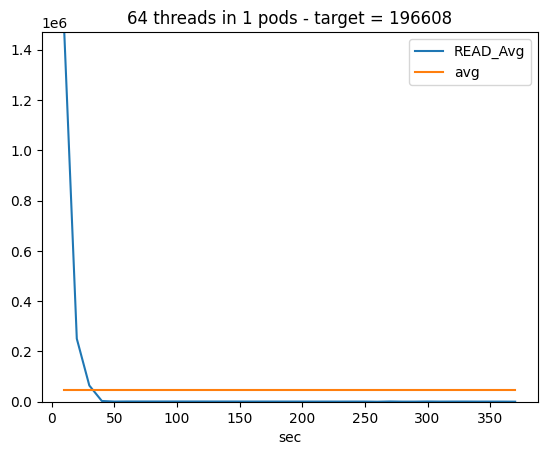

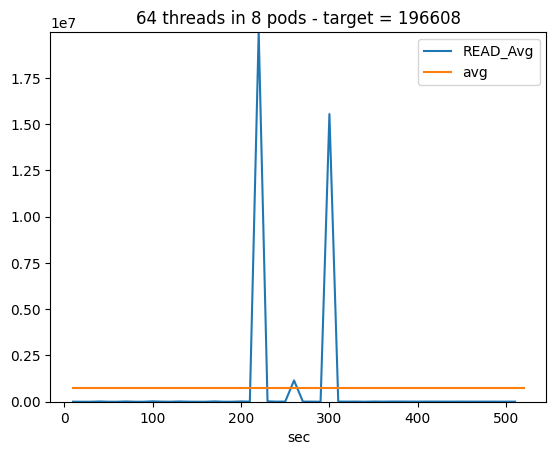

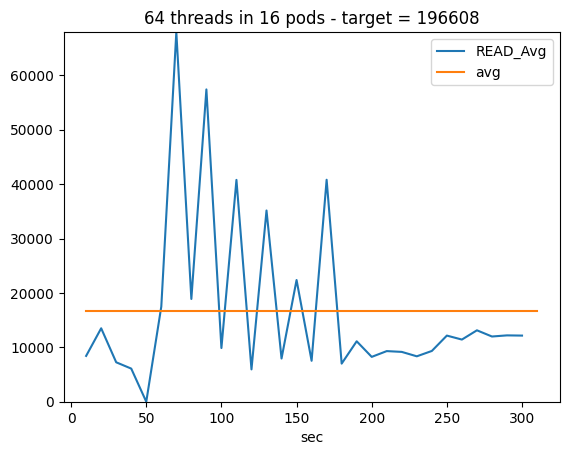

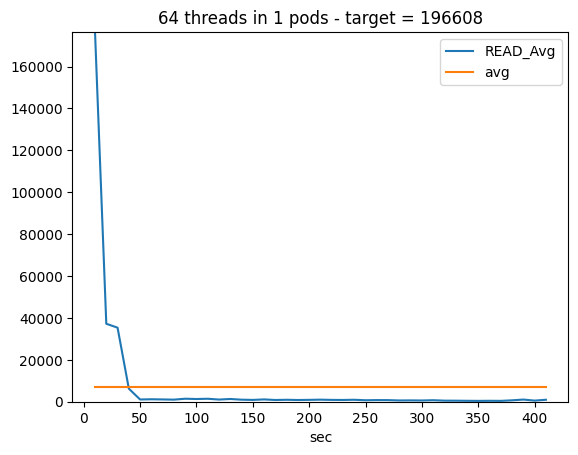

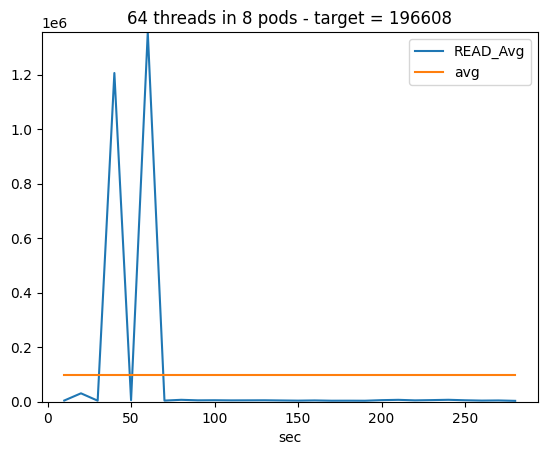

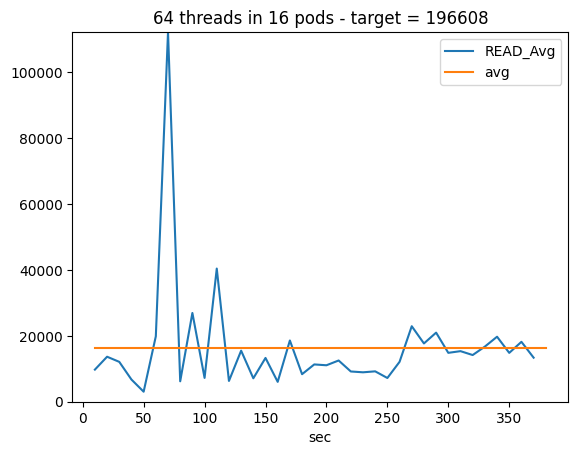

In [9]:
metric = 'READ_Avg'
cut_at = 1

list_configurations = list(df_benchmarks['configuration'].unique())

for configuration in list_configurations:
    print("Configuration:", configuration)
    list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
    #print(list_experiment_runs)
    for experiment_run in list_experiment_runs:
        #print("Experiment run", experiment_run)
        list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
        #print(list_runs)
        num_runs = len(list_runs)
        for client in list_runs:
            df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
            df_part = df_part[df_part['experiment_run'] == (experiment_run)]#['threads']
            df_part = df_part[df_part['client'] == (client)]#num_runs * int(client) -2)]
            #print(df_part.T)
            df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
            #print(df_total)
            threads = df_part['threads'].sum()
            pod_count = df_part['pod_count'].mean()
            target = df_part['target'].sum()
            #print(df_part['threads'])
            title = "{} threads in {} pods - target = {}".format(threads, int(pod_count), target)
            #plt.title(title)
            df_total[:-cut_at].plot(title=title, ylim=(0,df_total[metric].max()))
            #print(df_total[:-cut_at].mean().mean())

Configuration: PostgreSQL-64-8-196608


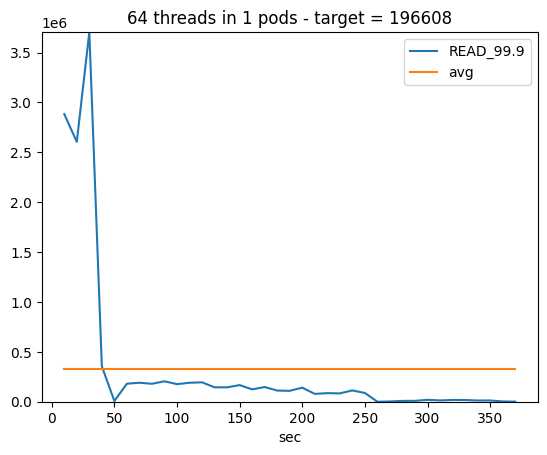

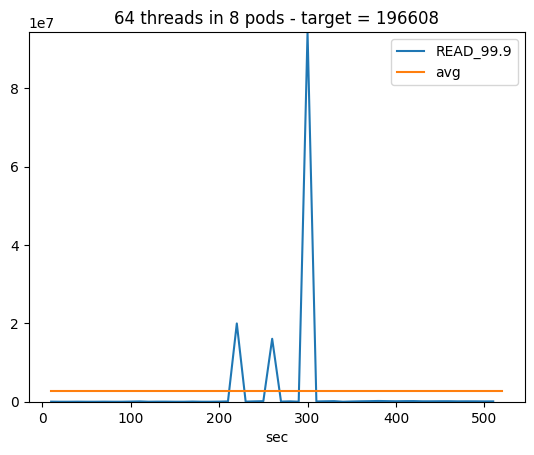

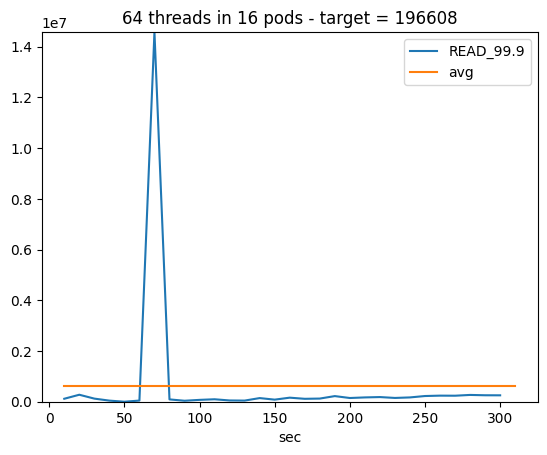

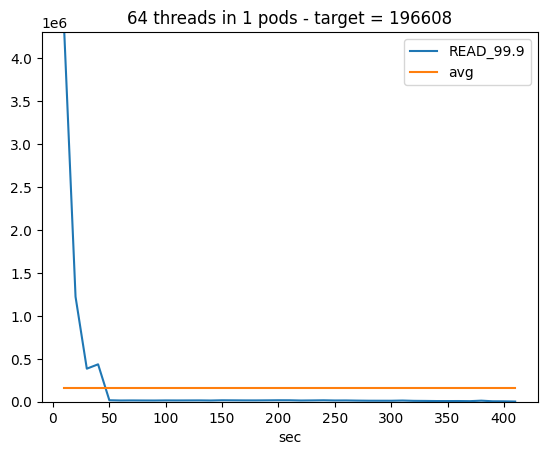

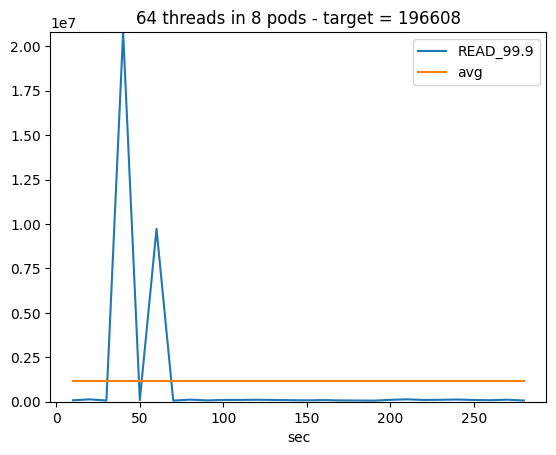

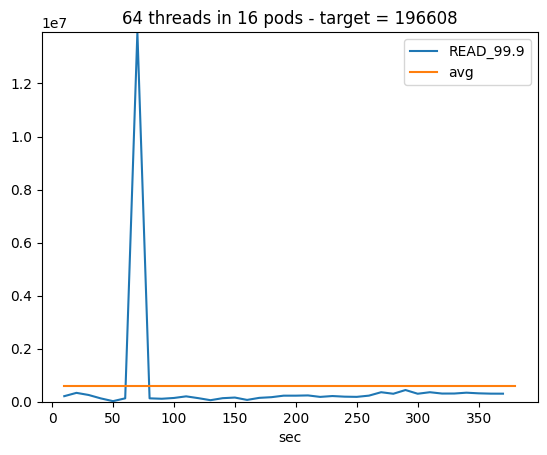

In [10]:
metric = 'READ_99.9'
cut_at = 1

list_configurations = list(df_benchmarks['configuration'].unique())

for configuration in list_configurations:
    print("Configuration:", configuration)
    list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
    #print(list_experiment_runs)
    for experiment_run in list_experiment_runs:
        #print("Experiment run", experiment_run)
        list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
        #print(list_runs)
        num_runs = len(list_runs)
        for client in list_runs:
            df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
            df_part = df_part[df_part['experiment_run'] == (experiment_run)]#['threads']
            df_part = df_part[df_part['client'] == (client)]#num_runs * int(client) -2)]
            #print(df_part.T)
            df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
            #print(df_total)
            threads = df_part['threads'].sum()
            pod_count = df_part['pod_count'].mean()
            target = df_part['target'].sum()
            #print(df_part['threads'])
            title = "{} threads in {} pods - target = {}".format(threads, int(pod_count), target)
            #plt.title(title)
            df_total[:-cut_at].plot(title=title, ylim=(0,df_total[metric].max()))
            #print(df_total[:-cut_at].mean().mean())

Configuration: PostgreSQL-64-8-196608


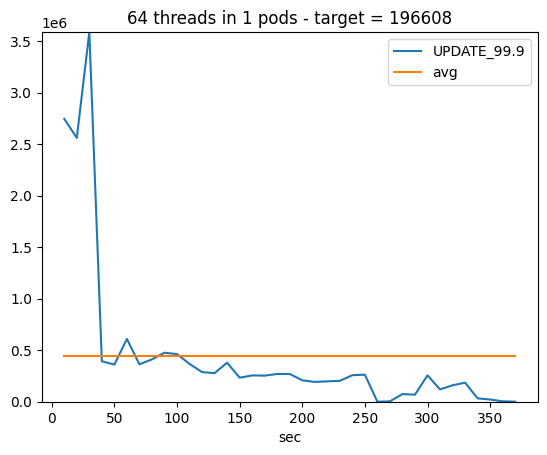

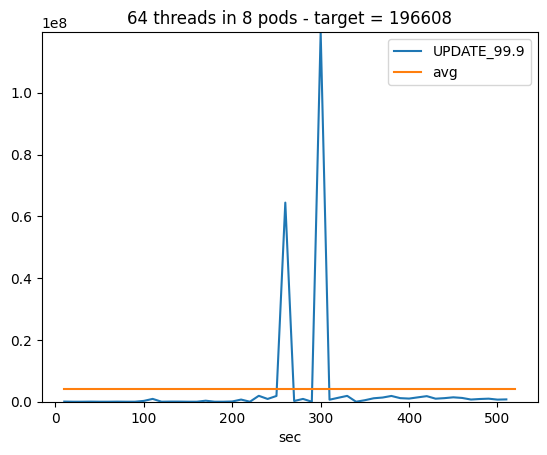

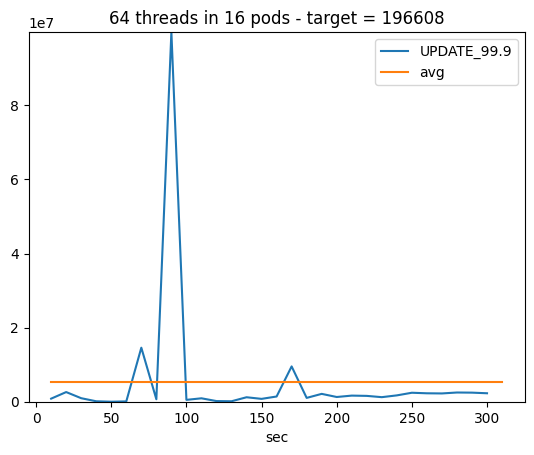

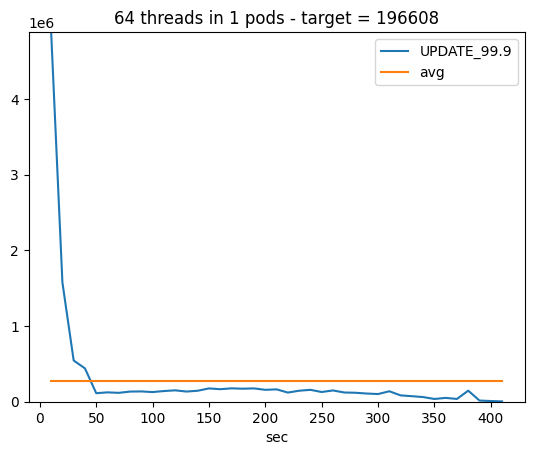

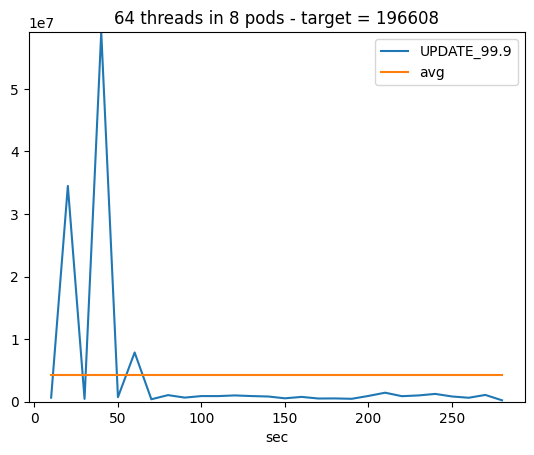

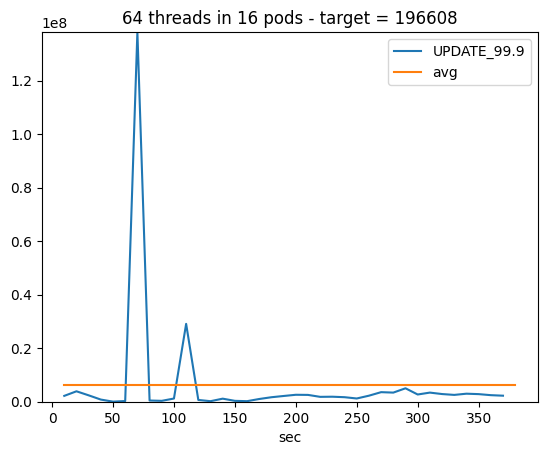

In [11]:
metric = 'UPDATE_99.9'
cut_at = 1

list_configurations = list(df_benchmarks['configuration'].unique())

for configuration in list_configurations:
    print("Configuration:", configuration)
    list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
    #print(list_experiment_runs)
    for experiment_run in list_experiment_runs:
        #print("Experiment run", experiment_run)
        list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
        #print(list_runs)
        num_runs = len(list_runs)
        for client in list_runs:
            df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
            df_part = df_part[df_part['experiment_run'] == (experiment_run)]#['threads']
            df_part = df_part[df_part['client'] == (client)]#num_runs * int(client) -2)]
            #print(df_part.T)
            df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
            #print(df_total)
            threads = df_part['threads'].sum()
            pod_count = df_part['pod_count'].mean()
            target = df_part['target'].sum()
            #print(df_part['threads'])
            title = "{} threads in {} pods - target = {}".format(threads, int(pod_count), target)
            #plt.title(title)
            df_total[:-cut_at].plot(title=title, ylim=(0,df_total[metric].max()))
            #print(df_total[:-cut_at].mean().mean())